# MOMENTUM AND GRADIENT NORMALIZATION
https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b  
https://pages.mini.pw.edu.pl/~karwowskij/mioad/wyklad2.pdf

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit

In [3]:
class MLP():
    def __init__(self, neurons, activation='sigmoid', activation_out='linear'):
        self.neurons = neurons
        self.weights = []
        self.biases = []
        self.activation = self.activ[activation]
        self.derivative = self.deriv[activation]
        self.outputActivation = self.activ[activation_out]
        self.outputDerivative = self.deriv[activation_out]
        self.dw_mean = []
        self.db_mean = []

        for i in range(len(self.neurons) - 1):
            self.weights += [np.random.uniform(-1, 1, neurons[i]
                                               * neurons[i + 1]).reshape(neurons[i], neurons[i + 1])]
            self.biases += [np.random.uniform(-1, 1,
                                              neurons[i + 1]).reshape(1, neurons[i+1])]

        
        self.mw = [np.zeros(w.shape) for w in self.weights]  # emthod weights
        self.mb = [np.zeros(b.shape) for b in self.biases]  # method biases

        pass

    activ = {
        'sigmoid': (lambda x: expit(x)),
        'tanh': (lambda x: np.tanh(x)),
        'Relu': (lambda x: np.multiply(x, x > 0)),
        'linear': (lambda x: np.array(x))
    }
    deriv = {
        'sigmoid': (lambda x: expit(x)*(1-expit(x))),
        'tanh': (lambda x: 1-x**2),
        'Relu': (lambda x: 1 * (x > 0)),
        'linear': (lambda x: 1)
    }
    
    def clear_mw_mb(self):
        self.mw = [np.zeros(w.shape) for w in self.weights]
        self.mb = [np.zeros(b.shape) for b in self.biases]


    def mse(self, y, y_hat):
        return np.square(np.subtract(y, y_hat)).mean()

    def forward(self, x):  # forwardujemy pojednynczy input przez sieć
        self.A = [x]
        self.Z = []

        for layer in range(len(self.neurons)-2):
            net = np.dot(self.A[-1], self.weights[layer]) + self.biases[layer]
            output = self.activation(net)
            self.Z += [net]
            self.A += [output]
        net = np.dot(self.A[-1], self.weights[-1]) + self.biases[-1]
        y_hat = self.outputActivation(net)

        self.Z += [net]
        self.A += [y_hat]

        return y_hat

    def backprop(self, y):
        m = y.shape[0]
        Errors = [None] * len(self.weights)

        Errors[-1] = y - self.A[-1]

        for i in reversed(range(len(Errors)-1)):
            Errors[i] = (np.dot(self.weights[i+1], Errors[i+1].T)
                         * self.derivative(self.Z[i]).T).T

        dw = [None] * len(Errors)
        db = [None] * len(Errors)

        for i, e in enumerate(Errors):
            dw[i] = np.dot(e.T, self.A[i]).T / m
            db[i] = np.dot(e.T, np.ones([m, 1])).T / m

        return (dw, db)

    def learn_batch(self, x, y, batch_size=10, iterations=500, learning_rate=0.001, method='classic', damping=0.4):
        
            
        np.random.seed(420)
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]

        for iteration in range(iterations):
            mse_prev = np.inf # so that it works when adapt_learning_rate = True
            i = 0
            while i < len(x): # dividing into batches
                x_batch = x[i: i+batch_size]
                y_batch = y[i: i+batch_size]
                i += batch_size

                self.forward(x_batch)
                (dw, db) = self.backprop(y_batch)

                self.dw_mean += [[np.mean(x) for x in dw]]
                self.db_mean += [[np.mean(x) for x in db]]

                if method == 'classic':
                    for j, w in enumerate(self.weights):
                        self.weights[j] = w + learning_rate*dw[j]
                    for j, b in enumerate(self.biases):
                        self.biases[j] = b + learning_rate*db[j]

                elif method == 'momentum':
                    for j, w in enumerate(self.weights):
                        self.mw[j] = damping * self.mw[j] + dw[j]
                        self.weights[j] = w + learning_rate * self.mw[j]
                    for j, b in enumerate(self.biases):
                        self.mb[j] = damping * self.mb[j] + db[j]
                        self.biases[j] = b + learning_rate*self.mb[j]

                elif method == 'RMSprop':
                    for j, w in enumerate(self.weights):
                        self.mw[j] = damping * self.mw[j] + (1-damping) * np.square(dw[j])
                        self.weights[j] = w + learning_rate * dw[j] / (np.sqrt(self.mw[j]) + 1e-8)
                    for j, b in enumerate(self.biases):
                        self.mb[j] = damping * self.mb[j] + (1-damping) * np.square(db[j])
                        self.biases[j] = b + learning_rate * db[j] / (np.sqrt(self.mb[j]) + 1e-8)



### niezbędne funkcje 

In [4]:
def plot_mse(iter, mse_classic, mse_momentum, mse_rms):
    plt.figure(figsize=(12, 8))
    plt.title("MSE values for different iteration number")
    plt.plot(iter, mse_classic, marker='o', markerfacecolor='c',
             markersize=3, color='c', linewidth=2, linestyle='dotted')
    plt.plot(iter, mse_momentum, marker='o', markerfacecolor='m',
             markersize=3, color='m', linewidth=2, linestyle='dotted')
    plt.plot(iter, mse_rms, marker='o', markerfacecolor='y',
             markersize=3, color='y', linewidth=2, linestyle='dotted')
    plt.legend(['classic', 'momentum', 'rms'])


def plot_train_test(x_train, y_train, x_test, y_test):
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Training set vs Test set")
    fig.set_size_inches(12,8)
    ax[0].plot(x_train, y_train, 'o', markersize = 3)
    ax[1].plot(x_test, y_test, 'o', markersize = 3)

def plot_compare_3_pred(x,y,y1,y2,y3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Classic, Momentum and RMSprop model comparison')
    fig.set_size_inches(20,5)
    ax1.set_title('Classic')
    ax1.scatter(x, y, s=10)
    ax1.scatter(x, y1, s=6)
    ax2.set_title('Momentum')
    ax2.scatter(x, y, s=10)
    ax2.scatter(x, y2, s=6)
    ax3.set_title('RMSprop')
    ax3.scatter(x, y, s=10)
    ax3.scatter(x, y3, s=6)
    print(f"MSE: , classic = {mse(y, y1)}, momentum = {mse(y, y2)}, RMSprop = {mse(y, y3)}")

def mse(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()


# square-large

In [5]:
os.chdir("C:/Users/mipec/school/sem6/Metody Inteligencji Obliczeniowej w Analizie Danych/dane/regression/")
os.getcwd()
data_train = pd.read_csv("square-large-training.csv", index_col = 0)
data_test = pd.read_csv("square-large-test.csv", index_col = 0)

X_train = np.asarray(data_train['x']).reshape(-1,1)
Y_train = np.asarray(data_train['y']).reshape(-1,1)

X_test = np.asarray(data_test['x']).reshape(-1,1)
Y_test = np.asarray(data_test['y']).reshape(-1,1)

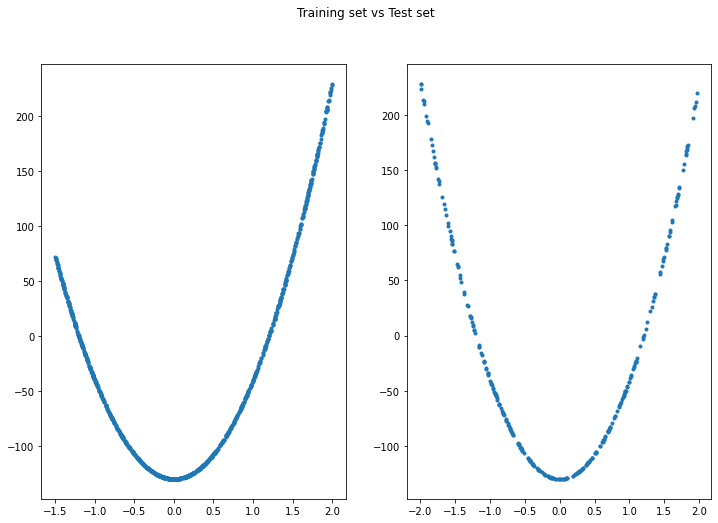

In [6]:
plot_train_test(X_train, Y_train, X_test, Y_test)

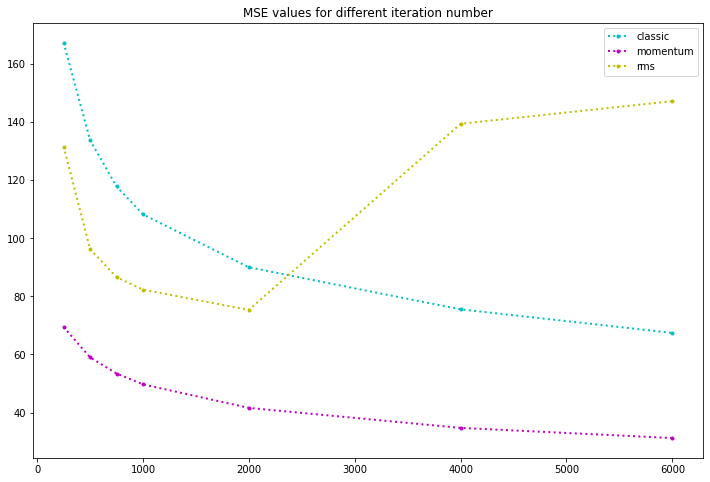

In [19]:
iterations = [250, 500, 750, 1000, 2000, 4000, 6000]
neurons = [1, 500, 1]

mse_classic = []
mse_momentum = []
mse_rmsprop = []

min_mse_classic = np.inf
min_mse_momentum = np.inf
min_mse_rmsprop = np.inf

mlp_classic_best = None
mlp_momentum_best = None
mlp_rmsprop_best = None

for iteration in iterations:
    mlp_classic = MLP(neurons)
    mlp_momentum = MLP(neurons)
    mlp_rmsprop = MLP(neurons)

    mlp_classic.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 20, learning_rate = 0.01, method = 'classic')
    y_pred_classic = mlp_classic.forward(X_test)
    mse_classic.append(mse(Y_test, y_pred_classic))
    if min_mse_classic > mse_classic[-1]:
        mlp_classic_best = mlp_classic
        min_mse_classic = mse_classic[-1]

    mlp_momentum.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 20, method = 'momentum', learning_rate = 0.01, damping = 0.9)
    y_pred_momentum = mlp_momentum.forward(X_test)
    mse_momentum.append(mse(Y_test, y_pred_momentum))
    if min_mse_momentum > mse_momentum[-1]:
        mlp_momentum_best = mlp_momentum
        min_mse_momentum = mse_momentum[-1]

    mlp_rmsprop.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 20, method = 'RMSprop', learning_rate = 0.01, damping = 0.85)
    y_pred_rmsprop = mlp_rmsprop.forward(X_test)
    mse_rmsprop.append(mse(Y_test, y_pred_rmsprop))
    if min_mse_rmsprop > mse_rmsprop[-1]:
        mlp_rmsprop_best = mlp_rmsprop
        min_mse_rmsprop = mse_rmsprop[-1]

y_pred_classic = mlp_classic_best.forward(X_test)
y_pred_momentum = mlp_momentum_best.forward(X_test)
y_pred_rmsprop = mlp_rmsprop_best.forward(X_test)

plot_mse(iterations, mse_classic, mse_momentum, mse_rmsprop)

być może ustawiona zbyt wysoka wartość tłumienia dla rmsprop, wydaje się być lepsze niż klasyczna propagacja wsteczna, natomiast najlepiej zdaje sobie radzić metoda momentum

MSE: , classic = 108.18539671709839, momentum = 49.716645437771945, RMSprop = 85.08975703949773


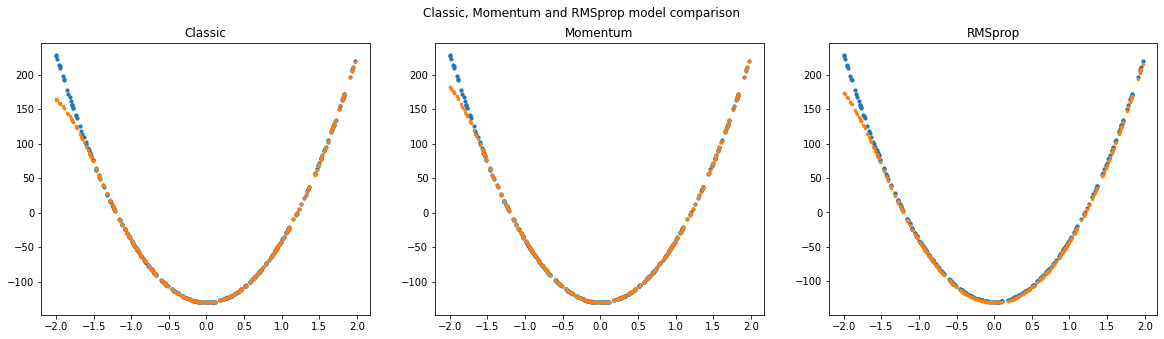

In [8]:
plot_compare_3_pred(X_test, Y_test, y_pred_classic, y_pred_momentum, y_pred_rmsprop)

In [9]:
mlp_momentum = MLP(neurons = [1,800,1])
MSE = [mse(mlp_momentum.forward(X_test), Y_test)]
lr = 0.01
min_mse = MSE[-1]
# prev_epoch_last = epoch
for epoch in range(100000):
    mlp_momentum.learn_batch(X_train, Y_train, iterations=1, batch_size=20, learning_rate=lr,
                                method='momentum', damping = 0.9)
    y_pred = mlp_momentum.forward(X_test)
    MSE.append(mse(y_pred, Y_test))
    if MSE[-1] < min_mse - 1:
        min_mse = MSE[-1]
    print(f"epoch = {epoch}, mse = {np.floor(MSE[-1]*1000)/1000}")
    if MSE[-1] < 1:
        break

# była podjęta próba trenowania modelu, żeby osiągnął MSE < 1, ale po kilkunastu godzinach pracy i MSE = 1.9 program przestał odpowiadać, i wszystkie zmienne(w tym trenowany model) zostały utracone

NameError: name 'store_vars' is not defined

była podjęta próba trenowania modelu, żeby osiągnął MSE < 1, ale po kilkunastu godzinach pracy i MSE = 1.9 program przestał odpowiadać, i wszystkie zmienne(w tym trenowany model) zostały utracone

# steps

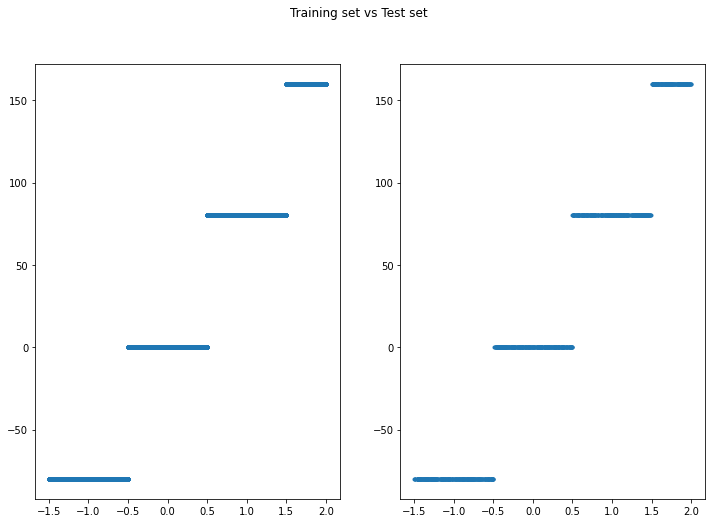

In [20]:
os.chdir("C:/Users/mipec/school/sem6/Metody Inteligencji Obliczeniowej w Analizie Danych/dane/regression/")
os.getcwd()
data_train = pd.read_csv("steps-large-training.csv", index_col = 0)
data_test = pd.read_csv("steps-large-test.csv", index_col = 0)

X_train = np.asarray(data_train['x']).reshape(-1,1)
Y_train = np.asarray(data_train['y']).reshape(-1,1)

X_test = np.asarray(data_test['x']).reshape(-1,1)
Y_test = np.asarray(data_test['y']).reshape(-1,1)

plot_train_test(X_train, Y_train, X_test, Y_test)

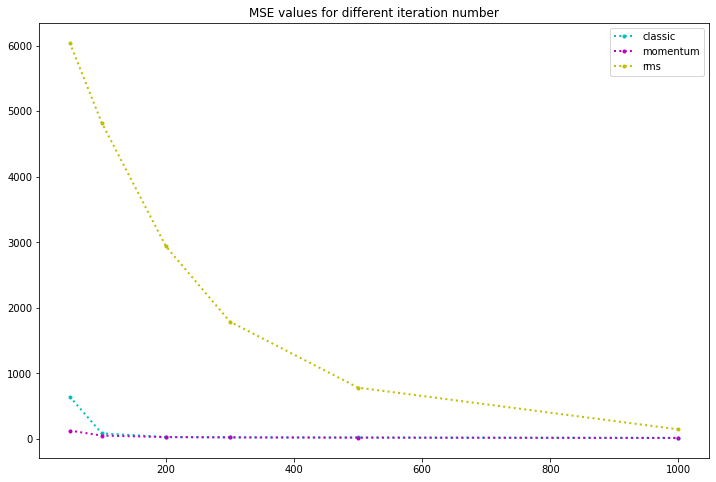

In [46]:
iterations = [50, 100, 200, 300, 500, 1000]
neurons=[1, 10, 10, 10, 10, 1]


mse_classic = []
mse_momentum = []
mse_rmsprop = []

min_mse_classic = np.inf
min_mse_momentum = np.inf
min_mse_rmsprop = np.inf

mlp_classic_best = None
mlp_momentum_best = None
mlp_rmsprop_best = None

for iteration in iterations:
    mlp_classic = MLP(neurons)
    mlp_momentum = MLP(neurons)
    mlp_rmsprop = MLP(neurons)

    mlp_classic.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 20, learning_rate = 0.0001, method = 'classic')
    y_pred_classic = mlp_classic.forward(X_test)
    mse_classic.append(mse(Y_test, y_pred_classic))
    if min_mse_classic > mse_classic[-1]:
        mlp_classic_best = mlp_classic
        min_mse_classic = mse_classic[-1]

    mlp_momentum.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 20, method = 'momentum', learning_rate = 0.0001, damping = 0.3)
    y_pred_momentum = mlp_momentum.forward(X_test)
    mse_momentum.append(mse(Y_test, y_pred_momentum))
    if min_mse_momentum > mse_momentum[-1]:
        mlp_momentum_best = mlp_momentum
        min_mse_momentum = mse_momentum[-1]

    mlp_rmsprop.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 20, method = 'RMSprop', learning_rate = 0.0001, damping = 0.7)
    y_pred_rmsprop = mlp_rmsprop.forward(X_test)
    mse_rmsprop.append(mse(Y_test, y_pred_rmsprop))
    if min_mse_rmsprop > mse_rmsprop[-1]:
        mlp_rmsprop_best = mlp_rmsprop
        min_mse_rmsprop = mse_rmsprop[-1]

y_pred_classic = mlp_classic_best.forward(X_test)
y_pred_momentum = mlp_momentum_best.forward(X_test)
y_pred_rmsprop = mlp_rmsprop_best.forward(X_test)

plot_mse(iterations, mse_classic, mse_momentum, mse_rmsprop)

In [40]:
# mlp_momentum = MLP(neurons = neurons)
# lr = 0.001
for i in range(100):
    mlp_momentum.learn_batch(X_train, Y_train, iterations = 100, batch_size = 20, method = 'momentum', learning_rate = lr, damping = 0.3)
    y_pred_momentum = mlp_momentum.forward(X_test)
    mse_momentum.append(mse(Y_test, y_pred_momentum))
    print(mse_momentum[-1])
    lr*=0.95

3.4191744310946377
3.370718999473646
3.3248513175100607
3.2812868802972037
3.2398605130592175
3.2005223345907936
3.1632951758929404
3.128249374343418
3.095483501242459
3.0650988330821383
3.037169560340115
3.0117185437885228
2.988706331880928


KeyboardInterrupt: 

udało się dotrenować model do MSE < 3, dzięki malejącym learning_rate (zajęło to około 10000 iteracji)

MSE: , classic = 8.138320135098978, momentum = 2.988706331880928, RMSprop = 19.23199651690392


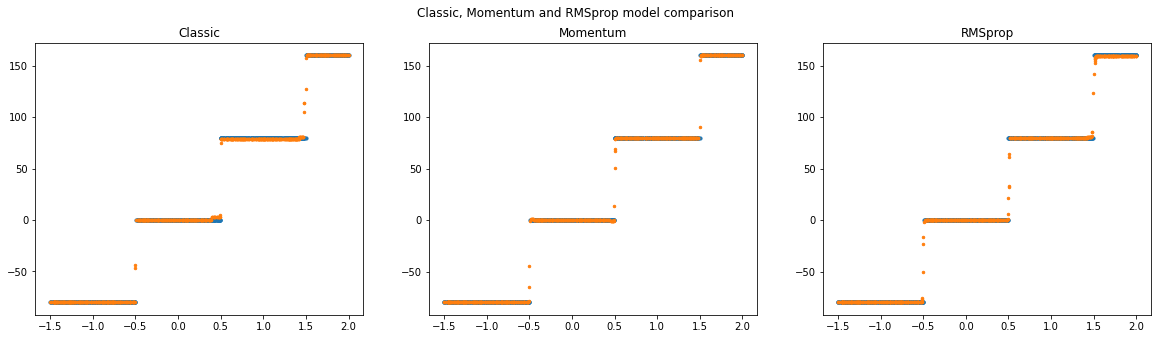

In [41]:
plot_compare_3_pred(X_test, Y_test, y_pred_classic, y_pred_momentum, y_pred_rmsprop)

# multimodal

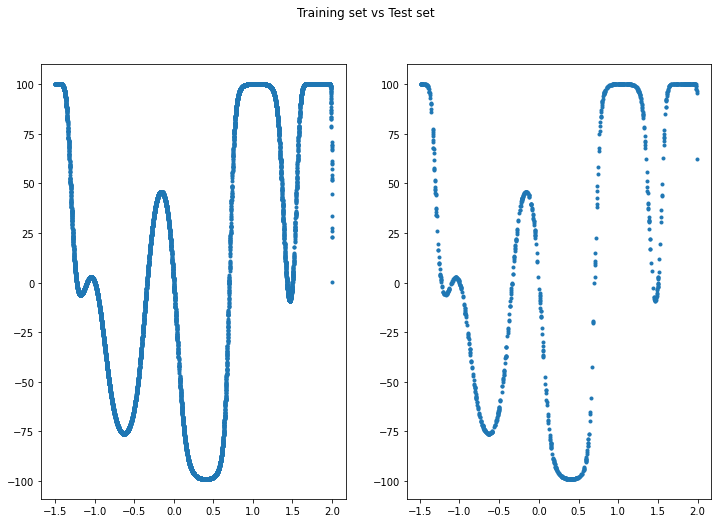

In [47]:
os.chdir("C:/Users/mipec/school/sem6/Metody Inteligencji Obliczeniowej w Analizie Danych/dane/regression/")
os.getcwd()
data_train = pd.read_csv("multimodal-large-training.csv")
data_test = pd.read_csv("multimodal-large-test.csv")

X_train = np.asarray(data_train['x']).reshape(-1,1)
Y_train = np.asarray(data_train['y']).reshape(-1,1)

X_test = np.asarray(data_test['x']).reshape(-1,1)
Y_test = np.asarray(data_test['y']).reshape(-1,1)

plot_train_test(X_train, Y_train, X_test, Y_test)

[1653.72878811388]
[1653.72878811388, 1445.2274437293377]
[1653.72878811388, 1445.2274437293377, 11.936075699238112]
[1653.72878811388, 1445.2274437293377, 11.936075699238112, 14.082263495410112]
[1653.72878811388, 1445.2274437293377, 11.936075699238112, 14.082263495410112, 10.682044575027936]
[1653.72878811388, 1445.2274437293377, 11.936075699238112, 14.082263495410112, 10.682044575027936, 10.528189895220047]


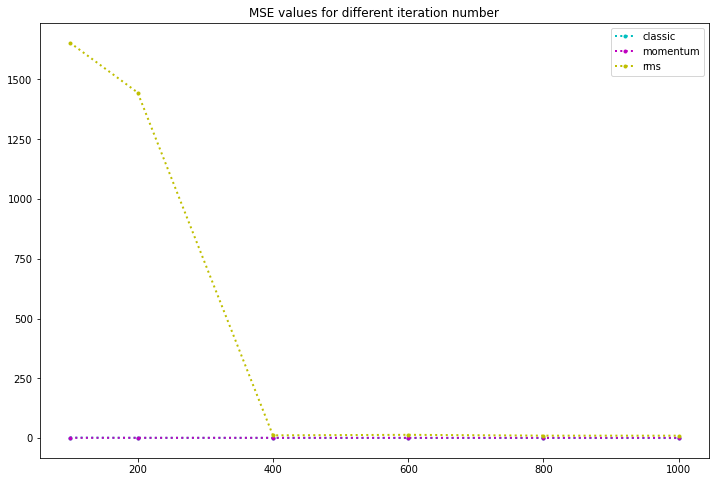

In [62]:
iterations = [100, 200, 400, 600, 800, 1000]
neurons=[1, 50, 50, 50, 1]

mse_classic = []
mse_momentum = []
mse_rmsprop = []

min_mse_classic = np.inf
min_mse_momentum = np.inf
min_mse_rmsprop = np.inf

mlp_classic_best = None
mlp_momentum_best = None
mlp_rmsprop_best = None

for iteration in iterations:
    mlp_classic = MLP(neurons)
    mlp_momentum = MLP(neurons)
    mlp_rmsprop = MLP(neurons)

    mlp_classic.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 20, learning_rate = 0.001, method = 'classic')
    y_pred_classic = mlp_classic.forward(X_test)
    mse_classic.append(mse(Y_test, y_pred_classic))
    if min_mse_classic > mse_classic[-1]:
        mlp_classic_best = mlp_classic
        min_mse_classic = mse_classic[-1]

    mlp_momentum.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 20, method = 'momentum', learning_rate = 0.001, damping = 0.8)
    y_pred_momentum = mlp_momentum.forward(X_test)
    mse_momentum.append(mse(Y_test, y_pred_momentum))
    if min_mse_momentum > mse_momentum[-1]:
        mlp_momentum_best = mlp_momentum
        min_mse_momentum = mse_momentum[-1]

    mlp_rmsprop.learn_batch(X_train, Y_train, iterations = iteration, batch_size = 50, method = 'RMSprop', learning_rate = 0.01, damping = 0.7)
    y_pred_rmsprop = mlp_rmsprop.forward(X_test)
    mse_rmsprop.append(mse(Y_test, y_pred_rmsprop))
    if min_mse_rmsprop > mse_rmsprop[-1]:
        mlp_rmsprop_best = mlp_rmsprop
        min_mse_rmsprop = mse_rmsprop[-1]
y_pred_classic = mlp_classic_best.forward(X_test)
y_pred_momentum = mlp_momentum_best.forward(X_test)
y_pred_rmsprop = mlp_rmsprop_best.forward(X_test)

plot_mse(iterations, mse_classic, mse_momentum, mse_rmsprop)

MSE: , classic = 0.6566721102936007, momentum = 1.4424300506793115, RMSprop = 10.528189895220047


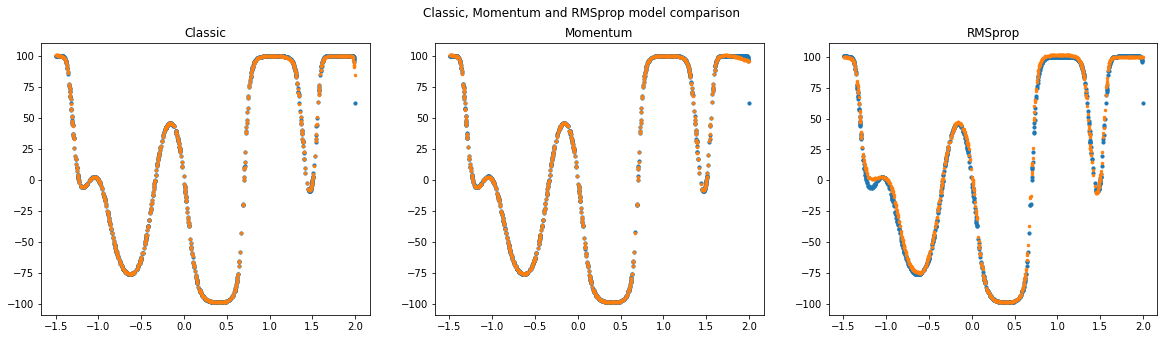

In [63]:
plot_compare_3_pred(X_test, Y_test, y_pred_classic, y_pred_momentum, y_pred_rmsprop)

model już tutaj daje radę osiągnąć wymagane MSE, tym razem momentum i klasyczny backprop radzą sobie podobnie  
dla tego zadania rmsprop radzi sobie znacznie gorzej niż pozostałe metody

MSE SQUARE-LARGE - udało się dojść poniżej 2, ale straciłem model  
MSE STEPS < 3  
MSE MULTIMODAL < 1  